<a href="https://colab.research.google.com/github/Soomro2023/Project4_CF23Qz0PfJlIm5KH/blob/main/Project_4_CNN_model_from_scratch_solution_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import and install required dependencies.

In [1]:
!pip install torchsummary

In [2]:
from __future__ import print_function, division
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import os
import time
import copy

import pandas as pd
from PIL import Image                             # Python Imaging Library (PIL)
import numpy as np
import shutil                                     # high level remote operation on file
from tqdm.notebook import tqdm                    # tqdm - Taqadum (arabic) mean "progress" - to create smart progress bar for the loop

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

'''import pytoch dependencies'''

from torchsummary import  summary
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Set the random seed for both numpy and pytorch for the getting the same results instead of random
np.random.seed(0)
torch.manual_seed(0)

In [4]:
#Check if the cuda is available otherwise the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device,"is available")

cuda is available


# 2. Load training and testing datasets.

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# Get training and testing dataset
train_flip_dir="/content/drive/MyDrive/images/training/flip/"
train_flip = os.listdir(train_flip_dir)

train_notflip_dir ="/content/drive/MyDrive/images/training/notflip/"
train_notflip = os.listdir(train_notflip_dir)

test_flip_dir= "/content/drive/MyDrive/images/testing/flip/"
test_flip = os.listdir(test_flip_dir)

test_notflip_dir = "/content/drive/MyDrive/images/testing/notflip/"
test_notflip = os.listdir(test_notflip_dir)

In [ ]:
#See the shape of each data folder
print('Total training fliped images:', len(train_flip))
print('Total training not fliped images:', len(train_notflip))
print('Total testing fliped images:', len(test_flip))
print('Total testing not fliped images:', len(test_notflip))

Total training fliped images: 1162
Total training not fliped images: 1230
Total testing fliped images: 290
Total testing not fliped images: 307


# 3. Image analysis and processing

### Get target labels and set 0 for flip and 1 for not flip.

In [ ]:
train_not_flipped = np.array(train_notflip)
train_flipped = np.array(train_flip)

target_not_flip = np.ones(train_not_flipped.shape[0])  # 1: notflip

target_flip = np.zeros(train_flipped.shape[0])       # 0: flip

train_data = np.concatenate((train_not_flipped, train_flipped))
target = np.concatenate((target_not_flip, target_flip))

print(train_data.shape)
print(target.shape)

(2392,)
(2392,)


### Split training datasets into 90% training and 10% validation datasets

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(train_data, target, test_size = 0.1, random_state = 100)

print('There are {} train data, {} val data, {} train targets and {} val targets.'
.format(X_train.shape[0], X_val.shape[0], Y_train.shape[0], Y_val.shape[0]))

There are 2152 train data, 240 val data, 2152 train targets and 240 val targets.


### Training and validation data distribution - verifying if the training and validation data are balanced.

There are 1049 flip images in the training dataset
There are 1103 notflip images in the training dataset


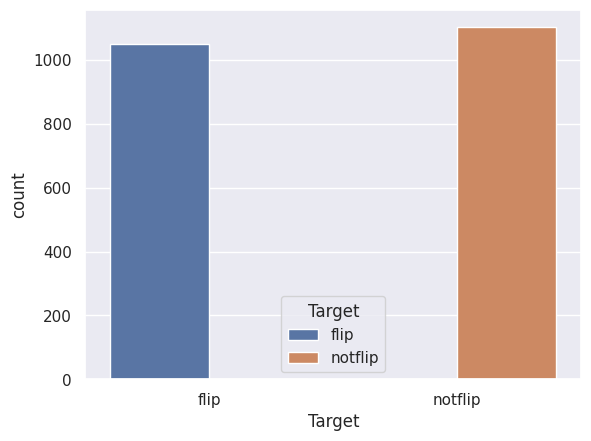

In [ ]:
sns.set()
def sns_plot(df, key_word):
  df = pd.DataFrame(df).rename(columns={0:'Target'})
  df = df.replace({0:'flip', 1:'notflip'})
  df['Target'] = pd.Categorical(df['Target'], categories=['flip', 'notflip'])
  flip_count = df[df['Target']=='flip'].count()
  notflip_count = df[df['Target']=='notflip'].count()
  print(f"There are {flip_count[0]} flip images in the {key_word}")
  print(f"There are {notflip_count[0]} notflip images in the {key_word}")
  sns.countplot(data = df, x = 'Target', hue = 'Target')

sns_plot(Y_train, 'training dataset')

There are 113 flip images in the validation dataset
There are 127 notflip images in the validation dataset


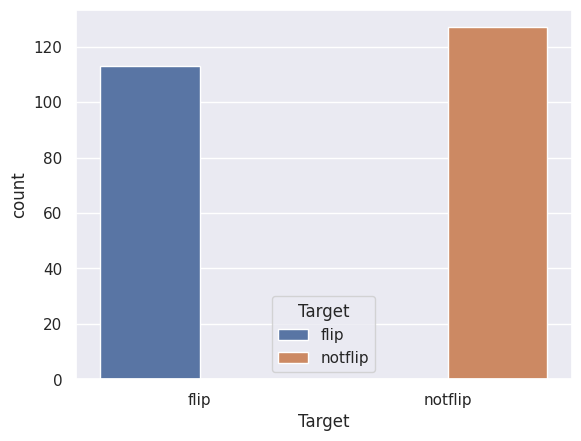

In [ ]:
sns_plot(Y_val, 'validation dataset')

In [ ]:
# # run this code for the first time only to save validation dataset
# os.mkdir('/content/drive/MyDrive/images/valid')
# valid_flip_dir='/content/drive/MyDrive/images/valid/flip'
# valid_notflip_dir='/content/drive/MyDrive/images/valid/notflip'
# os.mkdir(valid_flip_dir)
# os.mkdir(valid_notflip_dir)

# for i,j in zip(X_val,Y_val):

#   if j ==0:# 0 --> flip
#     shutil.move(train_flip_dir+i,valid_flip_dir)
#   else:
#     shutil.move(train_notflip_dir+i,valid_notflip_dir)

### Find minimum height and width of images for cropping images uniformly.

In [ ]:
height_list=[]
width_list=[]

for h in [test_flip_dir,train_flip_dir, train_notflip_dir, test_notflip_dir]:

    list_all = os.listdir(h)

    for w in list_all:
        filename = os.path.join(h,w)
        img = Image.open(filename)
        height_list.append(img.size[1])
        width_list.append(img.size[0])

print("The minimum width in the images data is:", min(width_list))
print("The minimum height in the images data is:", min(height_list))

The minimum width in the images data is: 1080
The minimum height in the images data is: 1920


In [ ]:
#Set the minimum size of images i.e., 1080 as their width and height for cropping
crop_size=(1080,1080)

### Test an image with set crop_size

size of a test image is (1080, 1920)


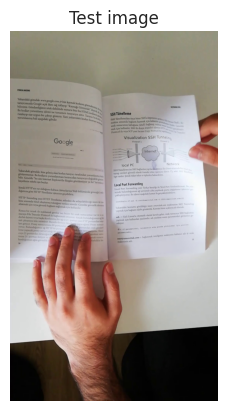

In [ ]:
# a test image example
test_image= Image.open(test_flip_dir+test_flip[0])
print("size of a test image is", test_image.size)
sns.set_style("ticks")
plt.title('Test image')
plt.axis('off')
plt.imshow(test_image)

size of a cropped test image is (1080, 1080)


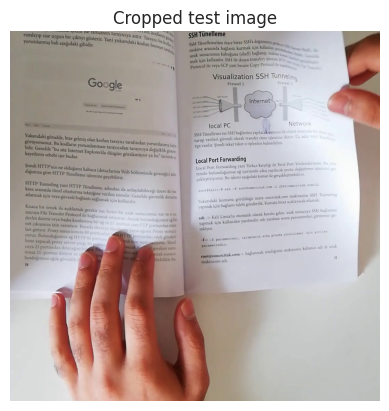

In [ ]:
# cropping the test image with set crop size
cropped_image=transforms.CenterCrop(size=crop_size)(test_image)
print("size of a cropped test image is", cropped_image.size)
sns.set_style("ticks")
plt.title('Cropped test image')
plt.axis('off')
plt.imshow(cropped_image)

### Resizing the test cropped image for transforming it as arbitary neural network input, i.e., 244 x 244

size of a resized cropped test image is (244, 244)


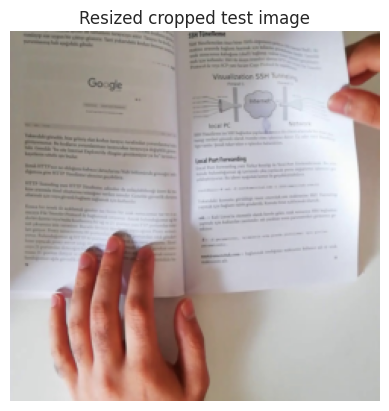

In [ ]:
#resize the cropped image
resized_image=transforms.Resize(size=(244,244))(cropped_image)
print("size of a resized cropped test image is", resized_image.size)
sns.set_style("ticks")
plt.title('Resized cropped test image')
plt.axis('off')
plt.imshow(resized_image)

(<matplotlib.image.AxesImage at 0x7bd1c0582530>,
 Text(0.5, 1.0, 'Resized cropped test image'))

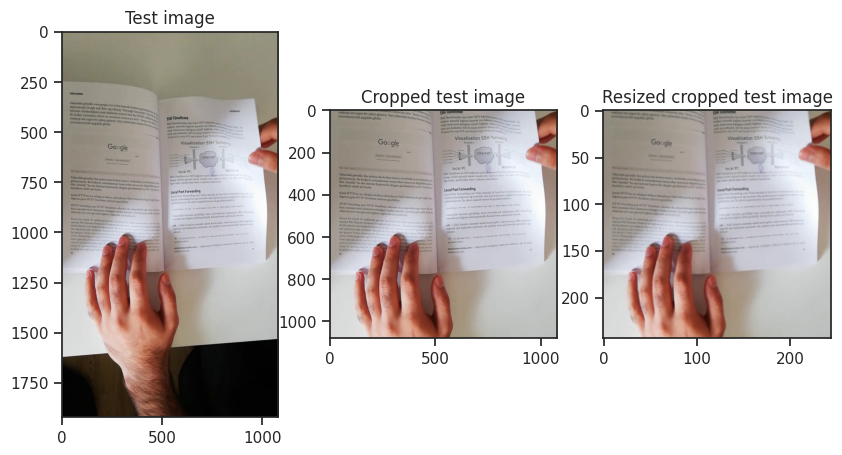

In [ ]:
sns.set_style("ticks")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))
ax1.imshow(test_image), ax1.set_title('Test image')
ax2.imshow(cropped_image), ax2.set_title('Cropped test image')
ax3.imshow(resized_image), ax3.set_title('Resized cropped test image')

# 4. Predictive Modeling

### Convolutional neural network (CNN) without data augmentation

In [11]:
#CNN transformer
CNN_transforms = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}

In [12]:
data_dir = "/content/drive/MyDrive/images/"

In [13]:
# load training and validation datasets

CNN_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          CNN_transforms[x])
                  for x in ['training', 'valid']}

CNN_train_loader = DataLoader(dataset=CNN_datasets['training'], shuffle=True, batch_size=8)
CNN_val_loader = DataLoader(dataset=CNN_datasets['valid'], shuffle=True, batch_size=1)

In [14]:
CNN_datasets['valid'].class_to_idx
idx2class = {v: k for k, v in CNN_datasets['valid'].class_to_idx.items()}
idx2class

{0: 'flip', 1: 'notflip'}

In [15]:
inputs, classes = next(iter(CNN_train_loader))

#get size of the image tensor
inputs.shape
#(batch, channels, height, width)

torch.Size([8, 3, 224, 224])

In [16]:
#get class names
dataset_sizes = {x: len(CNN_datasets[x]) for x in ['training', 'valid']}
class_names = CNN_datasets['training'].classes
class_names

['flip', 'notflip']

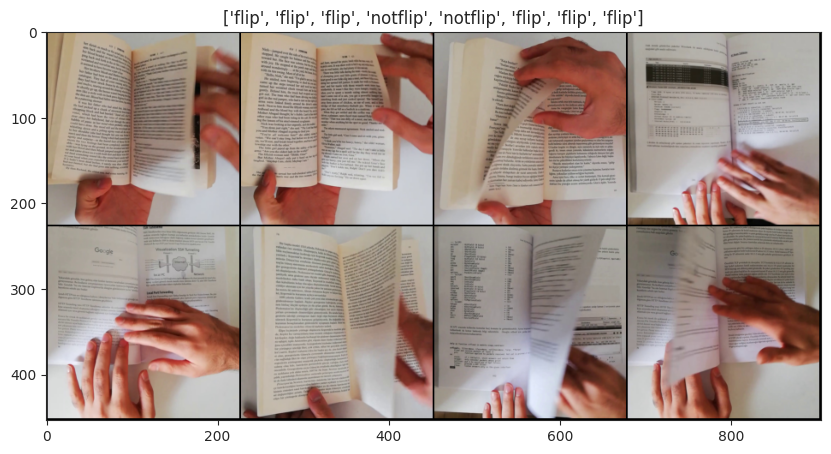

In [17]:
# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(inputs, nrow=4)#  nrow: Number of images displayed in each row of the grid.
sns.set_style("ticks")
plt.figure(figsize = (10,10))
plt.title([class_names[x] for x in classes])
plt.imshow(single_batch_grid.permute(1, 2, 0),)

In [18]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)

    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [19]:
from sklearn.metrics import f1_score
def binary_F1(y_pred, y_test):
  y_pred_tag = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_tag, dim = 1)

  F1_score = f1_score(y_test.cpu().data, y_pred_tags.cpu())
  F1_score = F1_score * 100

  return F1_score

In [20]:
#define 3 dictionaries which will store the accuracy/epoch, F1_score and loss/epoch for both train and validation sets.
accuracy_stats_CNN = {
    'train': [],
    "val": []
}

F1score_stats_CNN = {
    'train': [],
    "val": []
}

loss_stats_CNN = {
    'train': [],
    "val": []
}

In [21]:
# Define the model
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True), nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.25),
        )

    self.linear_layers = nn.Sequential(
        nn.Linear(128 * 14 * 14, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(256,10),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(10,2)
        )

    # Defining the forward pass
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x


In [22]:
CNN_model = Net()
CNN_model.to(device)
print(CNN_model)
criterion = nn.CrossEntropyLoss()#
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Con

In [23]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1 = 0
    CNN_model.train()
    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = CNN_model(X_train_batch).squeeze()

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)

        train_f1 = binary_F1(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        train_epoch_f1 += train_f1.item()

    # VALIDATION
    with torch.no_grad():
        CNN_model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        val_epoch_f1 = 0
        for X_val_batch, y_val_batch in CNN_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = CNN_model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_f1 = binary_F1(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            val_epoch_f1 += val_f1.item()
    loss_stats_CNN['train'].append(train_epoch_loss/len(CNN_train_loader))
    loss_stats_CNN['val'].append(val_epoch_loss/len(CNN_val_loader))
    accuracy_stats_CNN['train'].append(train_epoch_acc/len(CNN_train_loader))
    accuracy_stats_CNN['val'].append(val_epoch_acc/len(CNN_val_loader))
    F1score_stats_CNN['train'].append(train_epoch_f1/len(CNN_train_loader))
    F1score_stats_CNN['val'].append(val_epoch_f1/len(CNN_val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(CNN_train_loader):.5f} | Val Loss: {val_epoch_loss/len(CNN_val_loader):.5f} | Train Acc: {train_epoch_acc/len(CNN_train_loader):.3f}| Val Acc: {val_epoch_acc/len(CNN_val_loader):.3f}| Train F1: {train_epoch_f1/len(CNN_train_loader):.3f}| Val F1: {val_epoch_f1/len(CNN_val_loader):.3f}')


Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 0.66544 | Val Loss: 0.84117 | Train Acc: 62.138| Val Acc: 56.250| Train F1: 48.514| Val F1: 17.083
Epoch 02: | Train Loss: 0.48186 | Val Loss: 0.72442 | Train Acc: 78.219| Val Acc: 68.750| Train F1: 73.217| Val F1: 43.750
Epoch 03: | Train Loss: 0.32924 | Val Loss: 0.41653 | Train Acc: 85.457| Val Acc: 80.000| Train F1: 81.197| Val F1: 51.667
Epoch 04: | Train Loss: 0.21638 | Val Loss: 1.69447 | Train Acc: 93.833| Val Acc: 70.833| Train F1: 92.120| Val F1: 52.917
Epoch 05: | Train Loss: 0.19298 | Val Loss: 0.29491 | Train Acc: 94.294| Val Acc: 90.833| Train F1: 93.574| Val F1: 45.833
Epoch 06: | Train Loss: 0.14598 | Val Loss: 0.78826 | Train Acc: 94.788| Val Acc: 72.917| Train F1: 93.590| Val F1: 26.667
Epoch 07: | Train Loss: 0.15485 | Val Loss: 0.83115 | Train Acc: 96.007| Val Acc: 76.250| Train F1: 94.448| Val F1: 52.917
Epoch 08: | Train Loss: 0.18073 | Val Loss: 0.81949 | Train Acc: 93.279| Val Acc: 86.667| Train F1: 92.017| Val F1: 51.250
Epoch 09: | Trai

Text(0.5, 0.98, 'CNN without data augmentation')

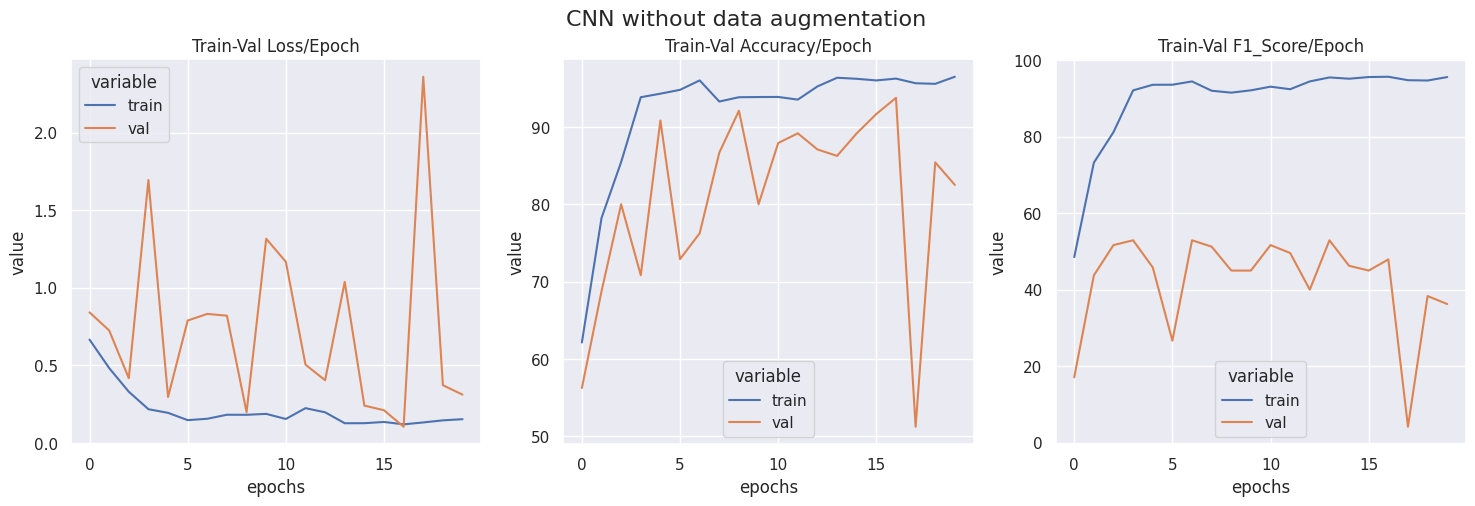

In [24]:
sns.set()
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_CNN).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_df = pd.DataFrame.from_dict(F1score_stats_CNN).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_CNN).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[1]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_f1_df, x = "epochs", y="value", hue="variable",  ax=axes[2]).set_title('Train-Val F1_Score/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Loss/Epoch')
fig.suptitle('CNN without data augmentation', fontsize=16)

In [25]:
#save the model
torch.save(CNN_model.state_dict(), "/content/drive/MyDrive/images/cnn_model.ckpt")

In [26]:
#This function will be used for all models for testing
def valid_batch_loop(model_test,validloader):

        valid_loss = 0.0
        valid_acc = 0.0
        final_y_pred_list=[]
        final_y_true_list=[]
        for images,labels in tqdm(validloader):

            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            logits = model_test(images)
            acc,y_pred_list,y_true_list=binary_acc_test(logits,labels)
            final_y_pred_list.extend(y_pred_list)
            final_y_true_list.extend(y_true_list)
            valid_acc = valid_acc + acc

        return valid_acc / len(validloader),final_y_pred_list,final_y_true_list

In [27]:
#This function calculate the accuracy and 2 lists, one of predictions and the other for true labels for each input.
def binary_acc_test(y_pred, y_test):
    y_pred_list=[]
    y_true_list=[]
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    y_pred_list.append(y_pred_tags.cpu().numpy())
    y_true_list.append(y_test.cpu().numpy())
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc,y_pred_list,y_true_list

In [28]:
#load the best model to our device
cnn_model = Net().to(device)
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/images/cnn_model.ckpt'))

<All keys matched successfully>

In [29]:
#define test dataset and test dataloader
CNN_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/testing/', transform=CNN_transforms['valid'])
CNN_test_loader = DataLoader(dataset=CNN_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [30]:
#define the eval mode
cnn_model.eval()
#Check the test accuracy
avg_test_acc_cnn,final_y_pred_list_cnn,final_y_true_list_cnn = valid_batch_loop(cnn_model,CNN_test_loader)
print("Test Accuracy of CNN: {}".format(avg_test_acc_cnn))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Accuracy of CNN: 83.24958038330078


In [31]:
report_cnn = classification_report([i[0] for i in final_y_true_list_cnn], [i[0] for i in final_y_pred_list_cnn],digits=4)

In [32]:
print('\033[1;32m Classification report of CNN test model trained without data augmentation \n')

print('\033[1;34m', report_cnn)

 Classification report of CNN test model trained without data augmentation 

               precision    recall  f1-score   support

           0     0.7513    0.9793    0.8503       290
           1     0.9726    0.6938    0.8099       307

    accuracy                         0.8325       597
   macro avg     0.8620    0.8366    0.8301       597
weighted avg     0.8651    0.8325    0.8295       597



Text(0.5, 0.98, 'Confusion matrix of CNN test model trained without data augmentation')

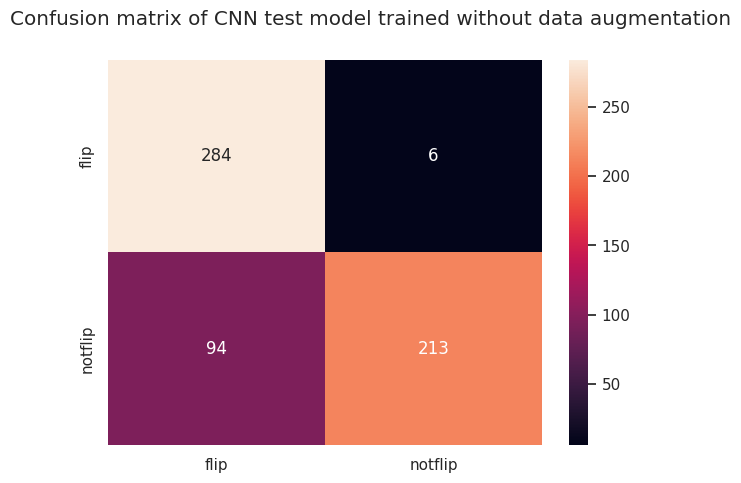

In [33]:
confusion_matrix_df_cnn = pd.DataFrame(confusion_matrix(final_y_true_list_cnn, final_y_pred_list_cnn)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix_df_cnn, annot=True, ax=ax, fmt='g')
fig.suptitle('Confusion matrix of CNN test model trained without data augmentation')

### CNN with data augmentation: horizontal and vertical flipping, random rotation and random cropping

In [34]:
#CNN with data augmentation transformation applied only on training dataset
CNN_transforms_aug = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(degrees=15),
        # transforms.RandomCrop((224, 224), padding = 10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
}

In [35]:
data_dir = "/content/drive/MyDrive/images/"

# load training and validation datasets

CNN_aug_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          CNN_transforms_aug[x])
                  for x in ['training', 'valid']}

CNN_aug_train_loader = DataLoader(dataset=CNN_aug_datasets['training'], shuffle=True, batch_size=8)
CNN_aug_val_loader = DataLoader(dataset=CNN_aug_datasets['valid'], shuffle=True, batch_size=1)

In [36]:
#define 3 dictionaries which will store the accuracy/epoch, F1_score and loss/epoch for both train and validation sets.
accuracy_stats_CNN_aug = {
    'train': [],
    "val": []
}

F1score_stats_CNN_aug = {
    'train': [],
    "val": []
}

loss_stats_CNN_aug = {
    'train': [],
    "val": []
}

In [37]:
CNN_model_aug = Net()
CNN_model_aug.to(device)
criterion = nn.CrossEntropyLoss()#
optimizer_aug = optim.Adam(CNN_model_aug.parameters(), lr=0.001)

In [38]:
print("Begin CNN training with data augmentation.")

for e in tqdm(range(1, 21)):

    # TRAINING
    train_epoch_loss_aug = 0
    train_epoch_acc_aug = 0
    train_epoch_f1_aug = 0

    CNN_model_aug.train()

    for X_train_batch_aug, y_train_batch_aug in CNN_aug_train_loader:
        X_train_batch_aug, y_train_batch_aug = X_train_batch_aug.to(device), y_train_batch_aug.to(device)

        optimizer_aug.zero_grad()

        y_train_pred_aug = CNN_model_aug(X_train_batch_aug).squeeze()

        train_loss_aug = criterion(y_train_pred_aug, y_train_batch_aug)
        train_acc_aug = binary_acc(y_train_pred_aug, y_train_batch_aug)

        train_f1_aug = binary_F1(y_train_pred_aug, y_train_batch_aug)

        train_loss_aug.backward()

        optimizer_aug.step()

        train_epoch_loss_aug += train_loss_aug.item()
        train_epoch_acc_aug += train_acc_aug.item()
        train_epoch_f1_aug += train_f1_aug.item()

    # VALIDATION
    with torch.no_grad():

        CNN_model_aug.eval()

        val_epoch_loss_aug = 0
        val_epoch_acc_aug = 0
        val_epoch_f1_aug = 0

        for X_val_batch_aug, y_val_batch_aug in CNN_aug_val_loader:

            X_val_batch_aug, y_val_batch_aug = X_val_batch_aug.to(device), y_val_batch_aug.to(device)

            y_val_pred_aug = CNN_model_aug(X_val_batch_aug).squeeze()

            y_val_pred_aug = torch.unsqueeze(y_val_pred_aug, 0)

            val_loss_aug = criterion(y_val_pred_aug, y_val_batch_aug)

            val_acc_aug = binary_acc(y_val_pred_aug, y_val_batch_aug)

            val_f1_aug = binary_F1(y_val_pred_aug, y_val_batch_aug)

            val_epoch_loss_aug += val_loss_aug.item()

            val_epoch_acc_aug += val_acc_aug.item()

            val_epoch_f1_aug += val_f1_aug.item()

    loss_stats_CNN_aug['train'].append(train_epoch_loss_aug/len(CNN_aug_train_loader))

    loss_stats_CNN_aug['val'].append(val_epoch_loss_aug/len(CNN_aug_val_loader))

    accuracy_stats_CNN_aug['train'].append(train_epoch_acc_aug/len(CNN_aug_train_loader))

    accuracy_stats_CNN_aug['val'].append(val_epoch_acc_aug/len(CNN_aug_val_loader))

    F1score_stats_CNN_aug['train'].append(train_epoch_f1_aug/len(CNN_aug_train_loader))

    F1score_stats_CNN_aug['val'].append(val_epoch_f1_aug/len(CNN_aug_val_loader))

    print(f'Epoch {e+0:02}:| Train Loss: {train_epoch_loss_aug/len(CNN_aug_train_loader):.5f} | Val Loss: {val_epoch_loss_aug/len(CNN_aug_val_loader):.5f} | Train Acc: {train_epoch_acc_aug/len(CNN_aug_train_loader):.3f}| Val Acc: {val_epoch_acc_aug/len(CNN_aug_val_loader):.3f} | Train F1: {train_epoch_f1_aug/len(CNN_aug_train_loader):.3f} | Val F1: {val_epoch_f1_aug/len(CNN_aug_val_loader):.3f}')


Begin CNN training with data augmentation.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01:| Train Loss: 0.72031 | Val Loss: 0.54443 | Train Acc: 57.788| Val Acc: 78.750 | Train F1: 40.674 | Val F1: 51.667
Epoch 02:| Train Loss: 0.59482 | Val Loss: 0.54442 | Train Acc: 62.706| Val Acc: 70.000 | Train F1: 47.757 | Val F1: 29.167
Epoch 03:| Train Loss: 0.59586 | Val Loss: 0.38763 | Train Acc: 67.758| Val Acc: 82.500 | Train F1: 64.595 | Val F1: 52.917
Epoch 04:| Train Loss: 0.55130 | Val Loss: 0.45223 | Train Acc: 75.089| Val Acc: 72.083 | Train F1: 77.534 | Val F1: 52.917
Epoch 05:| Train Loss: 0.54111 | Val Loss: 0.31384 | Train Acc: 73.714| Val Acc: 82.917 | Train F1: 76.823 | Val F1: 52.917
Epoch 06:| Train Loss: 0.44658 | Val Loss: 0.27247 | Train Acc: 80.327| Val Acc: 85.833 | Train F1: 81.925 | Val F1: 50.000
Epoch 07:| Train Loss: 0.45854 | Val Loss: 0.22949 | Train Acc: 81.546| Val Acc: 89.583 | Train F1: 82.158 | Val F1: 52.917
Epoch 08:| Train Loss: 0.43007 | Val Loss: 0.25247 | Train Acc: 81.424| Val Acc: 87.083 | Train F1: 82.109 | Val F1: 52.917
Epoch 09

Text(0.5, 0.98, 'CNN with data augmentation')

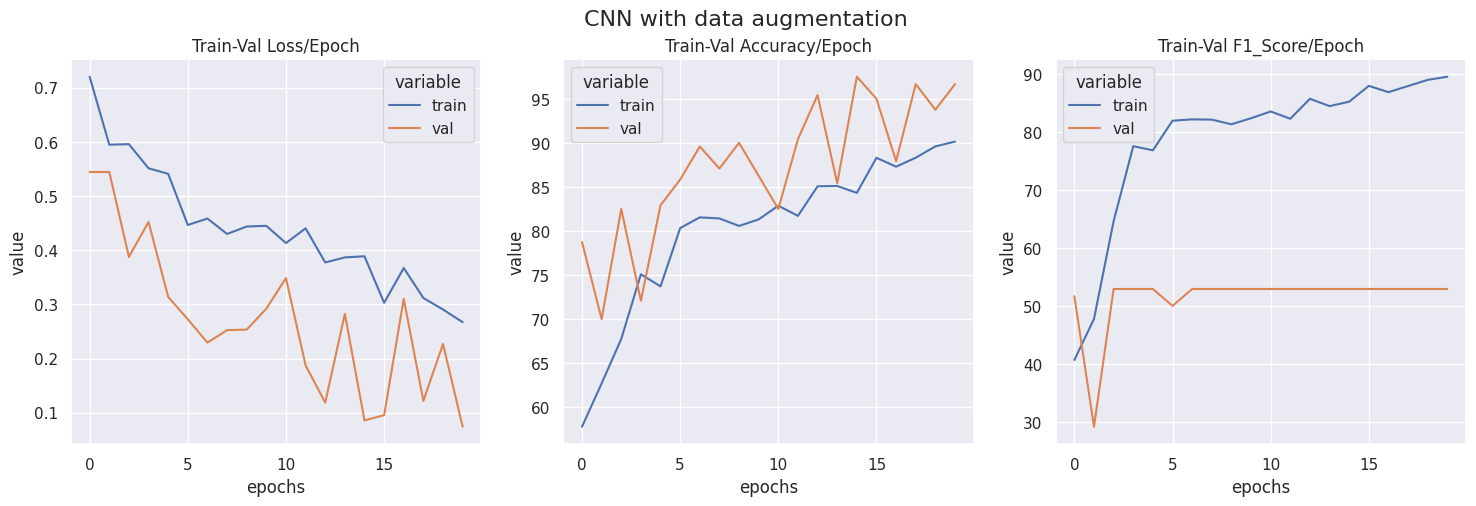

In [39]:
sns.set()
train_val_acc_aug_df = pd.DataFrame.from_dict(accuracy_stats_CNN_aug).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_aug_df = pd.DataFrame.from_dict(F1score_stats_CNN_aug).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_aug_df = pd.DataFrame.from_dict(loss_stats_CNN_aug).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.lineplot(data=train_val_acc_aug_df, x = "epochs", y="value", hue="variable",  ax=axes[1]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_f1_aug_df, x = "epochs", y="value", hue="variable",  ax=axes[2]).set_title('Train-Val F1_Score/Epoch')
sns.lineplot(data=train_val_loss_aug_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Loss/Epoch')
fig.suptitle('CNN with data augmentation', fontsize=16)

In [40]:
#save the model
torch.save(CNN_model_aug.state_dict(), "/content/drive/MyDrive/images/cnn_aug_model.ckpt")

In [41]:
#load the best model to our device
cnn_model_aug = Net().to(device)
cnn_model_aug.load_state_dict(torch.load('/content/drive/MyDrive/images/cnn_aug_model.ckpt'))

<All keys matched successfully>

In [42]:
#define test dataset and test dataloader
CNN_aug_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/testing/', transform=CNN_transforms_aug['valid'])
CNN_aug_test_loader = DataLoader(dataset=CNN_aug_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [43]:
#define the eval mode
cnn_model_aug.eval()
#Check the test accuracy
avg_test_acc_cnn_aug,final_y_pred_list_cnn_aug,final_y_true_list_cnn_aug = valid_batch_loop(cnn_model_aug,CNN_aug_test_loader)
print("Test Accuracy CNN_aug: {}".format(avg_test_acc_cnn_aug))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Accuracy CNN_aug: 95.14237976074219


In [44]:
report_cnn_aug = classification_report([i[0] for i in final_y_true_list_cnn_aug], [i[0] for i in final_y_pred_list_cnn_aug],digits=4)

In [46]:
print('\033[1;32m Classification report of CNN test model trained with data augmentation \n')
print('\033[1;34m', report_cnn_aug)

 Classification report of CNN test model trained with data augmentation 

               precision    recall  f1-score   support

           0     1.0000    0.9000    0.9474       290
           1     0.9137    1.0000    0.9549       307

    accuracy                         0.9514       597
   macro avg     0.9568    0.9500    0.9511       597
weighted avg     0.9556    0.9514    0.9512       597



# Results (Comparison b/w CNN without and with data augmentation)

Text(0.5, 0.98, 'Confusion matrix comparision')

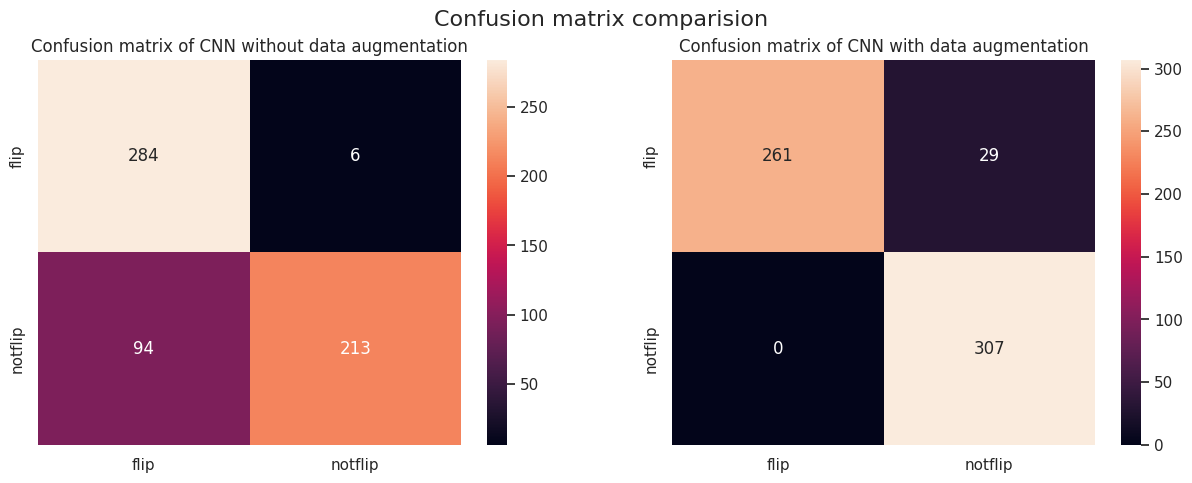

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.heatmap(data=confusion_matrix_df_cnn, annot=True, fmt='g', ax=axes[0]).set_title('Confusion matrix of CNN without data augmentation')
sns.heatmap(data=confusion_matrix_df_cnn_aug, annot=True, fmt='g', ax=axes[1]).set_title('Confusion matrix of CNN with data augmentation')
fig.suptitle('Confusion matrix comparision', fontsize=16)

In [58]:
print("\tComparision between CNN without and with dataaugmentation models \n")
print('-'*75)
print('model                 |   Accuracy    |   Precision  |  recall   |   F1-score')
print('-'*75)
print(" CNN w/o data-aug     |    83.25 %    |    86.51 %   |   83.25 % |   82.95 % ")
print("\033[1;34m CNN with data-aug    |    95.14 %    |    95.56 %   |   95.14 % |   95.12 % ")

	Comparision between CNN without and with dataaugmentation models 

---------------------------------------------------------------------------
model                 |   Accuracy    |   Precision  |  recall   |   F1-score
---------------------------------------------------------------------------
 CNN w/o data-aug     |    83.25 %    |    86.51 %   |   83.25 % |   82.95 % 
 CNN with data-aug    |    95.14 %    |    95.56 %   |   95.14 % |   95.12 % 


# Conclusion

CNN model was trained with and without data augmentation. Simple data augmentation techniques were used including horizontal and vertical flipping, random rotation and random cropping. Results shows that CNN model with data augmentation improved F1 score from 82.15 % to 95.12 % on the test data. Data size matters here, more data or different data augmenting can improve the result. We will use pretrained models trained on huge data, i.e., Resnet and densenet in our next solution.